# Распознавание объектов на изображениях с помощью сверточных нейронных сетей






##Недостатки полносвязных (многослойных) нейронных сетей


1.   Большое количество весов для обучения (28х28 = 784 входа и 400 + 10 нейронов => 638810 весов)

2.  Изображение представляется в виде плоского массива => теряется информация о топологии






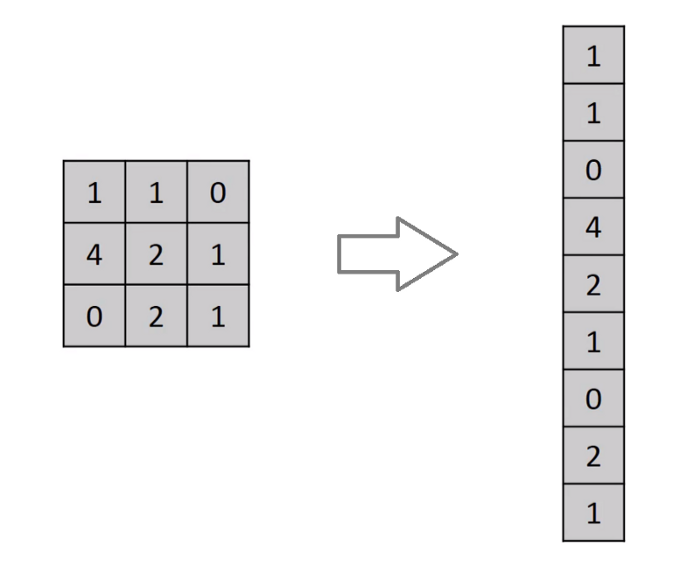

##Сверточные нейронные сети

Свёрточная нейронная сеть (англ. convolutional neural network, CNN) — специальная архитектура искусственных нейронных сетей, предложенная Яном Лекуном в 1988 году и нацеленная на эффективное распознавание образов. Использует некоторые представления об особенностях зрительной коры мозга.

Сверточные нейронные сети обеспечивают частичную устойчивость к изменениям масштаба, смещениям, поворотам, смене ракурса и прочим искажениям.

CNN состоит из разных видов слоев: сверточные (convolutional) слои, субдискретизирующие (sub-sampling или pooling layers, подвыборка) слои и слои «обычной» нейронной сети – персептрона

![4r8-t4d26oc1pw5tt3pd373qa2g[1].png](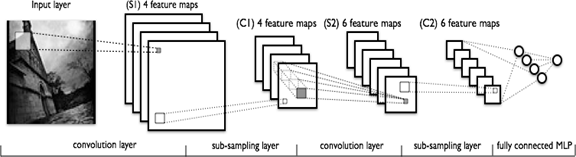)

Первые два типа слоев (convolutional, subsampling или pooling layers), чередуясь между собой, формируют входной вектор признаков для многослойного персептрона. 

Название архитектура сети получила из-за наличия операции свёртки, суть которой в том, что каждый фрагмент изображения умножается на матрицу (ядро)

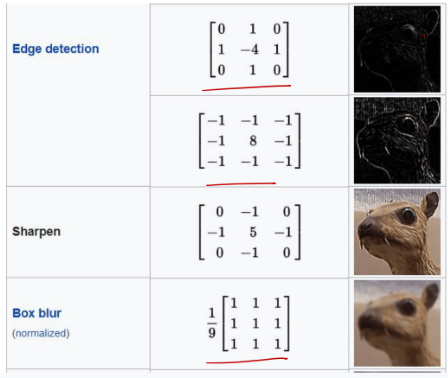

свёртки поэлементно, а результат суммируется и записывается в аналогичную позицию выходного изображения.

![2D_Convolution_Animation[1].gif](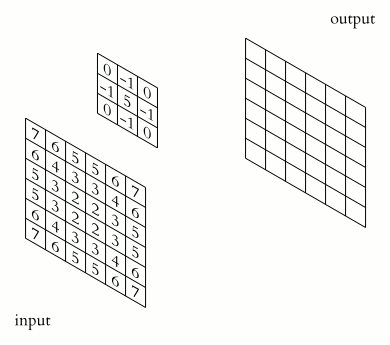)

![2d-covolutions[1].gif](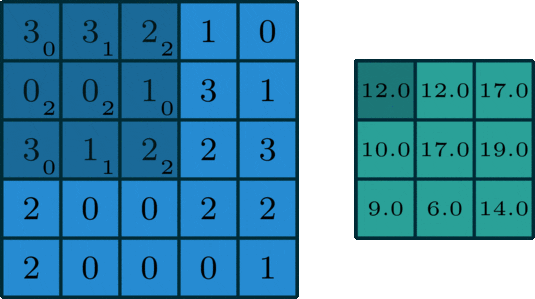)

Работа свёрточной нейронной сети обычно интерпретируется как переход от конкретных особенностей изображения к более абстрактным деталям, и далее к ещё более абстрактным деталям вплоть до выделения понятий высокого уровня. При этом сеть самонастраивается и вырабатывает сама необходимую иерархию абстрактных признаков (последовательности карт признаков), фильтруя маловажные детали и выделяя существенное.



Слой пулинга (иначе подвыборки, субдискретизации) представляет собой нелинейное уплотнение карты признаков, при этом группа пикселей (обычно размера 2×2) уплотняется до одного пикселя, проходя нелинейное преобразование. Наиболее употребительна при этом функция максимума. Преобразования затрагивают непересекающиеся прямоугольники или квадраты, каждый из которых ужимается в один пиксель, при этом выбирается пиксель, имеющий максимальное значение. Операция пулинга позволяет существенно уменьшить пространственный объём изображения. Пулинг интерпретируется так: если на предыдущей операции свёртки уже были выявлены некоторые признаки, то для дальнейшей обработки настолько подробное изображение уже не нужно, и оно уплотняется до менее подробного. К тому же фильтрация уже ненужных деталей помогает не переобучаться. Слой пулинга, как правило, вставляется после слоя свёртки перед слоем следующей свёртки.

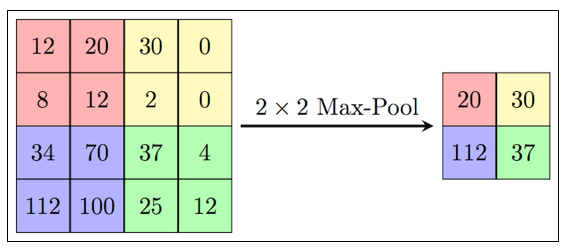

Может быть так:


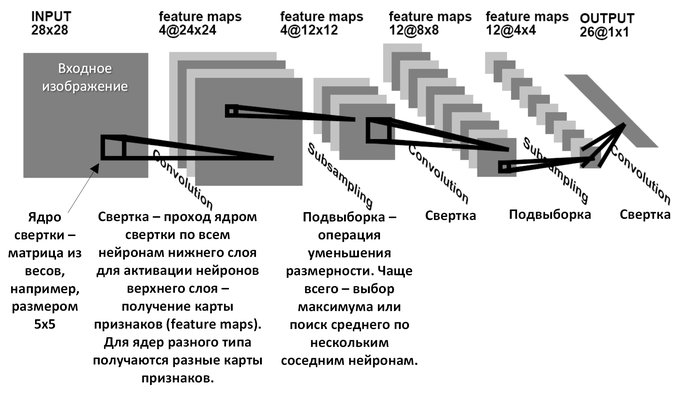

##Работа с набором данных fashion_mnist

Fashion MNIST содержит 70 000 изображений элементов одежды в 10 категориях в градациях серого. Изображения содержат предметы одежды в разрешении 28х28 пикселей.

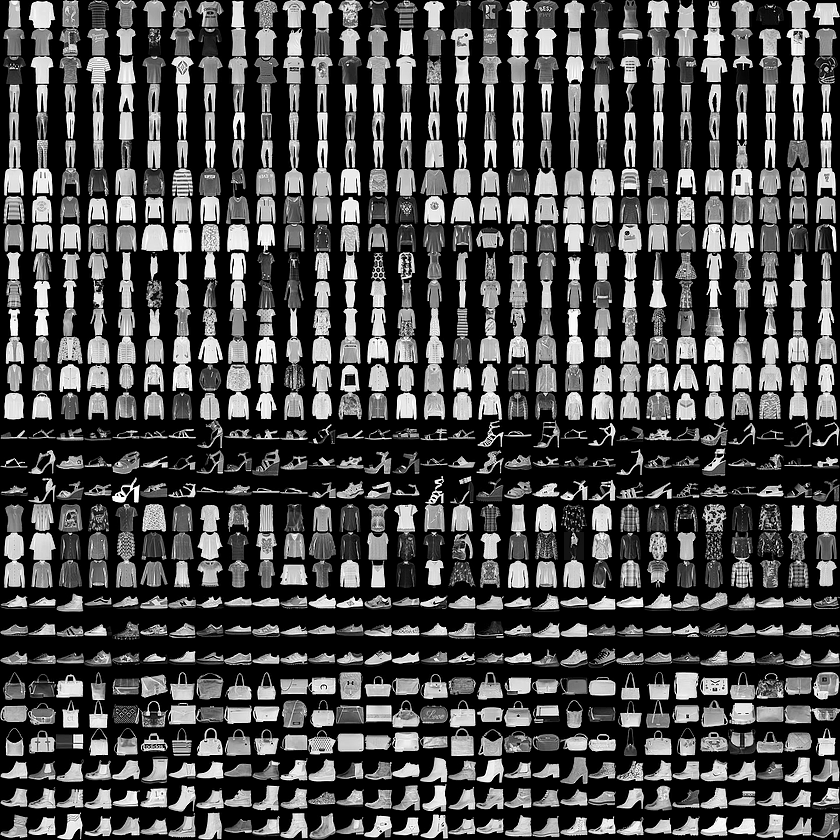

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.datasets import fashion_mnist
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline 

Создадим список с названиями классов

In [3]:
classes = ['Футболка', 'Брюки', 'Свитер', 'Платье', 'Пальто', 'Туфли', 'Рубашка', 'Кроссовки', 'Сумка', 'Ботинки']

## Подготовка данных для обучения сети

**Загрузим данные**

In [4]:
batch_size = 100 # Размер мини-выборки
nb_classes = 10 # Количество классов изображений
nb_epoch = 25 # Количество эпох для обучения
img_rows, img_cols = 28, 28 # Размер изображений

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


и отобобразим часть изображений

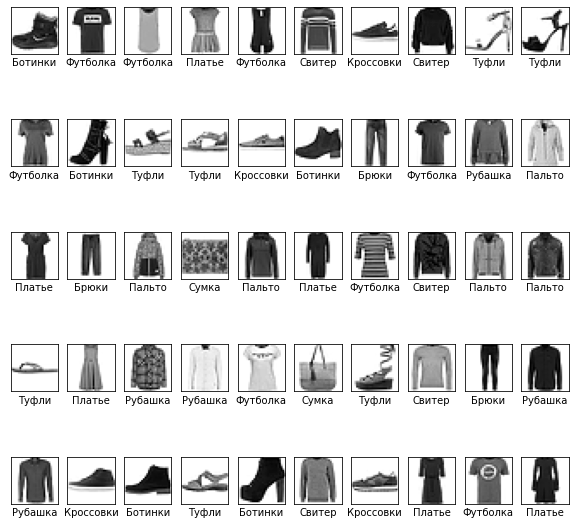

In [6]:
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(classes[y_train[i]])

**Преобразование размерности и нормализация данных**

Значение интенсивности пикселей в изображении находится в интервале [0,255]. Для наших целей их необходимо нормализовать - привести к значениям в интервале [0,1].

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Посмотрим, как выглядит ответ

In [8]:
n = 0
print(y_train[n])

9


Преобразуем метки классов в удобный для обучения нейронной сети формат **(one hot encoding)**

In [9]:
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

Теперь ответ выглядит так:

In [10]:
print(y_train[n])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Метка целевого класса в этом наборе имеет значение **1**

## Создаем нейронную сеть

Вот некоторые функции активации. В качестве функции активации используем для входного и последующих слоев ReLU, а для выходного слоя - SoftMax.

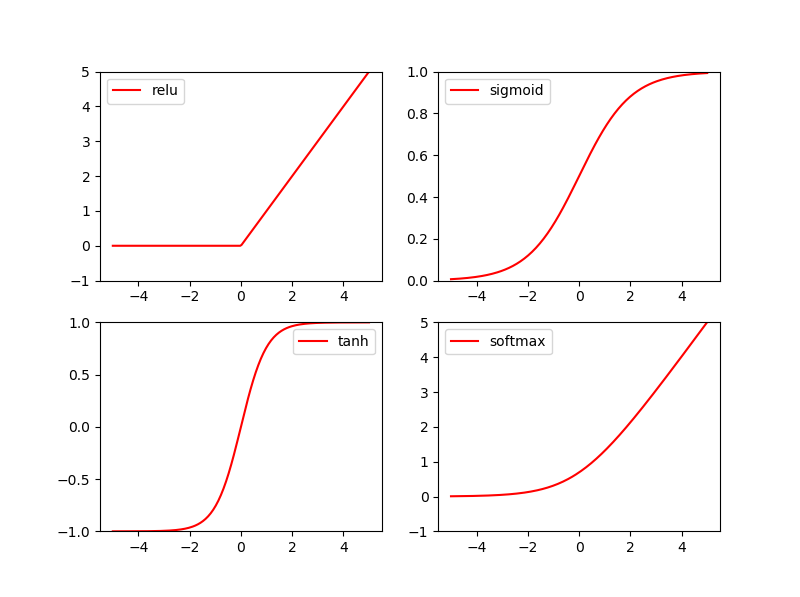

Конструируем нейронную сеть:

In [11]:
# Создаем последовательную модель нейронной сети
model = Sequential()
# Первый сверточный слой
model.add(Conv2D(img_rows, (3, 3), padding='same',
                        input_shape=(img_rows, img_cols, 1), activation='relu'))
# Второй сверточный слой
model.add(Conv2D(img_rows, (3, 3), activation='relu', padding='same'))
# Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Третий сверточный слой
model.add(Conv2D(2 * img_rows, (3, 3), padding='same', activation='relu'))
# Четвертый сверточный слой
model.add(Conv2D(2 * img_rows, (3, 3), activation='relu'))
# Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))
# Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
# Полносвязный слой для классификации
model.add(Dense(8 * img_rows, activation='relu'))
# Слой регуляризации Dropout
model.add(Dropout(0.5))
# Выходной полносвязный слой
model.add(Dense(nb_classes, activation='softmax'))

**Компилируем сеть**

Перед обучением модели ещё необходимо выполнить настройки при сборке модели (в методе compile):

* **loss** (функция потерь) - оценка желаемого значения относительно спрогнозированного, применим **categorical_crossentropy** (кроссэнтропию) - функцию штрафа, которую следует использовать для задач классификации, как у нас;
* **optimizer** (функция оптимизации) - агоритм "подгонки" внутренних параметров (весов и смещений) модели для минимизации функции потерь, optimizer="adam". Метод вычисляет индивидуальные адаптивные скорости обучения для различных параметров из оценок первого и второго моментов градиентов. Название получено из adaptive moment estimation - адаптивной оценки момента. Есть другие варианты [оптимизаторов](https://ru-keras.com/optimizer/);
* **metrics** (метрики) - используются для мониторинга процесса тренировки и тестирования, metrics=['accuracy'] значит, что мы будем вычислять в модели не только функцию штрафа, но и число правильно классифицированных примеров


In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 28)        280       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 28)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 28)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 56)        14168     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 56)        28280     
                                                        

## Обучаем нейронную сеть

In [13]:
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.2,
              shuffle=True,
              verbose=2)

Epoch 1/25
480/480 - 37s - loss: 0.6055 - accuracy: 0.7799 - val_loss: 0.3599 - val_accuracy: 0.8658 - 37s/epoch - 78ms/step
Epoch 2/25
480/480 - 7s - loss: 0.3738 - accuracy: 0.8631 - val_loss: 0.3058 - val_accuracy: 0.8859 - 7s/epoch - 14ms/step
Epoch 3/25
480/480 - 7s - loss: 0.3169 - accuracy: 0.8861 - val_loss: 0.2563 - val_accuracy: 0.9034 - 7s/epoch - 14ms/step
Epoch 4/25
480/480 - 7s - loss: 0.2833 - accuracy: 0.8977 - val_loss: 0.2391 - val_accuracy: 0.9107 - 7s/epoch - 14ms/step
Epoch 5/25
480/480 - 7s - loss: 0.2626 - accuracy: 0.9057 - val_loss: 0.2324 - val_accuracy: 0.9167 - 7s/epoch - 14ms/step
Epoch 6/25
480/480 - 7s - loss: 0.2464 - accuracy: 0.9098 - val_loss: 0.2107 - val_accuracy: 0.9210 - 7s/epoch - 14ms/step
Epoch 7/25
480/480 - 7s - loss: 0.2297 - accuracy: 0.9164 - val_loss: 0.2111 - val_accuracy: 0.9225 - 7s/epoch - 14ms/step
Epoch 8/25
480/480 - 7s - loss: 0.2187 - accuracy: 0.9190 - val_loss: 0.2075 - val_accuracy: 0.9231 - 7s/epoch - 14ms/step
Epoch 9/25
480

## Оценка качества обучения

Проверка качества работы на наборе данных для тестирования

In [14]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(x_test, y_test, verbose=0)
print("Точность работы на тестовых данных: %.2f%%" % (scores[1]*100))

Точность работы на тестовых данных: 93.24%


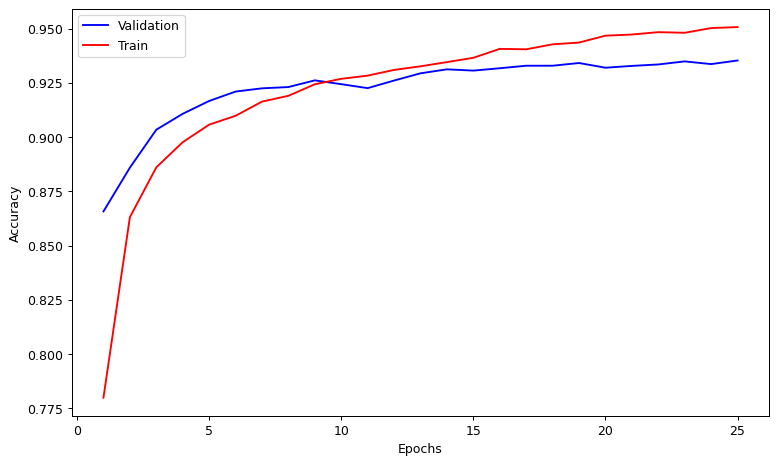

In [15]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.figure(figsize=(10,6), dpi=90)
plt.plot(epochs, val_acc_values, 'b', label='Validation')
plt.plot(epochs, acc_values, 'r', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Используем сеть для распознавания предметов одежды

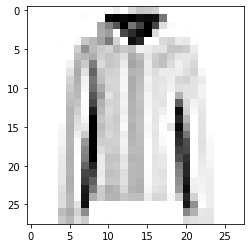

In [16]:
n_test = 6
plt.imshow(x_test[n_test].reshape(28, 28), cmap=plt.cm.binary)
plt.show()

**Запускаем распознавание и выводим результат**

In [17]:
x = x_test[n_test]
x = np.expand_dims(x, axis=0)
prediction = model.predict(x)
print(prediction)
prediction = np.argmax(prediction[0])
print("Номер класса:", prediction)
print("Название класса:", classes[prediction])

[[1.1487224e-10 2.4294690e-12 2.5038992e-04 1.7380478e-10 9.9960977e-01
  1.4309686e-15 1.3995380e-04 1.4860762e-16 5.7538939e-11 4.5483392e-14]]
Номер класса: 4
Название класса: Пальто


**Печатаем правильный ответ**

In [18]:
label = np.argmax(y_test[n_test])
print("Номер класса:", label)
print("Название класса:", classes[label])

Номер класса: 4
Название класса: Пальто


**Проверка на реальных картинках**

In [19]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('Файл(ы) "{name}" размером {length} байт загружен(ы)'.format(
      name=fn, length=len(uploaded[fn])))

Saving Ботинки.jpg to Ботинки.jpg
Saving Брюки.jpg to Брюки.jpg
Saving Пальто.jpg to Пальто.jpg
Saving Пальто2.jpg to Пальто2.jpg
Saving Платье.jpg to Платье.jpg
Saving Рубашка.jpg to Рубашка.jpg
Saving Свитер.jpg to Свитер.jpg
Saving Сумка.jpg to Сумка.jpg
Saving Футболка.jpg to Футболка.jpg
Файл(ы) "Ботинки.jpg" размером 3339 байт загружен(ы)
Файл(ы) "Брюки.jpg" размером 3146 байт загружен(ы)
Файл(ы) "Пальто.jpg" размером 3249 байт загружен(ы)
Файл(ы) "Пальто2.jpg" размером 3358 байт загружен(ы)
Файл(ы) "Платье.jpg" размером 4578 байт загружен(ы)
Файл(ы) "Рубашка.jpg" размером 5161 байт загружен(ы)
Файл(ы) "Свитер.jpg" размером 6579 байт загружен(ы)
Файл(ы) "Сумка.jpg" размером 3929 байт загружен(ы)
Файл(ы) "Футболка.jpg" размером 86055 байт загружен(ы)


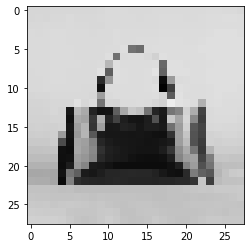

In [38]:
img_path = 'Сумка.jpg'
img = image.load_img(img_path, target_size=(28, 28), color_mode = "grayscale")
plt.imshow(img.convert('RGBA'))
plt.show()

In [39]:
x = image.img_to_array(img)
x = 255 - x
x /= 255
x = np.expand_dims(x, axis=0)
prediction = model.predict(x)
print(prediction)
prediction = np.argmax(prediction)
print("Номер класса:", prediction)
print("Название класса:", classes[prediction])

[[6.4710510e-01 1.6280687e-09 1.7141560e-01 4.3990069e-05 3.8507420e-07
  2.4373963e-07 4.5313785e-04 2.7454852e-10 1.8098150e-01 9.7437325e-10]]
Номер класса: 0
Название класса: Футболка


##Работа с набором данных CIFAR-10

Набор содержит 60000 картинок: 50000 (по 5000 каждого класса) в обучающей выборке + 10000 - в тестовой. Размер цветных изображений - 32х32


In [3]:
from keras.datasets import cifar10

In [5]:
# Размер мини-выборки
batch_size = 100
# Количество классов изображений
nb_classes = 10
# Количество эпох для обучения
nb_epoch = 25
# Размер изображений
img_rows, img_cols = 32, 32
# Количество каналов в изображении: RGB
img_channels = 3
# Названия классов из набора данных CIFAR-10
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

## Подготовка данных

**Загружаем данные**

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


**Просмотр примеров данных**

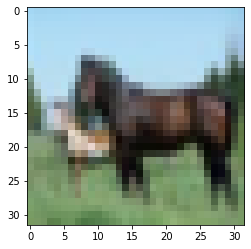

Номер класса: [7]
Тип объекта: лошадь


In [14]:
n = 12
plt.imshow(X_train[n])
plt.show()
print("Номер класса:", y_train[n])
print("Тип объекта:", classes[y_train[n][0]])

**Нормализуем данные**

In [15]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

**Преобразуем правильные ответы в формат one hot encoding**

In [16]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
print(Y_train[n])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## Создаем нейронную сеть

In [17]:
# Создаем последовательную модель
model = Sequential()
# Первый сверточный слой
model.add(Conv2D(img_rows, (3, 3), padding='same',
                        input_shape=(img_rows, img_cols, img_channels), activation='relu'))
# Второй сверточный слой
model.add(Conv2D(img_rows, (3, 3), activation='relu', padding='same'))
# Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Третий сверточный слой
model.add(Conv2D(2 * img_rows, (3, 3), padding='same', activation='relu'))
# Четвертый сверточный слой
model.add(Conv2D(2 * img_rows, (3, 3), activation='relu'))
# Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))
# Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
# Полносвязный слой для классификации
model.add(Dense(16 * img_rows, activation='relu'))
# Слой регуляризации Dropout
model.add(Dropout(0.5))
# Выходной полносвязный слой
model.add(Dense(nb_classes, activation='softmax'))

Dropout - техника борьбы с переобучением, когда с заданной вероятностью отключаются нейроны.

**Печатаем информацию о сети**

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

**Компилируем модель**

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [20]:
history = model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.1,
              shuffle=True,
              verbose=2)

Epoch 1/25
450/450 - 39s - loss: 1.6111 - accuracy: 0.4079 - val_loss: 1.2160 - val_accuracy: 0.5606 - 39s/epoch - 88ms/step
Epoch 2/25
450/450 - 9s - loss: 1.2041 - accuracy: 0.5714 - val_loss: 1.0243 - val_accuracy: 0.6414 - 9s/epoch - 20ms/step
Epoch 3/25
450/450 - 9s - loss: 1.0183 - accuracy: 0.6406 - val_loss: 0.8733 - val_accuracy: 0.6926 - 9s/epoch - 19ms/step
Epoch 4/25
450/450 - 9s - loss: 0.9071 - accuracy: 0.6806 - val_loss: 0.7791 - val_accuracy: 0.7272 - 9s/epoch - 20ms/step
Epoch 5/25
450/450 - 9s - loss: 0.8224 - accuracy: 0.7099 - val_loss: 0.7639 - val_accuracy: 0.7294 - 9s/epoch - 19ms/step
Epoch 6/25
450/450 - 9s - loss: 0.7566 - accuracy: 0.7348 - val_loss: 0.6980 - val_accuracy: 0.7546 - 9s/epoch - 20ms/step
Epoch 7/25
450/450 - 9s - loss: 0.7048 - accuracy: 0.7537 - val_loss: 0.6668 - val_accuracy: 0.7728 - 9s/epoch - 20ms/step
Epoch 8/25
450/450 - 9s - loss: 0.6640 - accuracy: 0.7650 - val_loss: 0.6561 - val_accuracy: 0.7672 - 9s/epoch - 19ms/step
Epoch 9/25
450

## Оцениваем качество обучения сети

In [21]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Точность работы на тестовых данных: %.2f%%" % (scores[1]*100))

Точность работы на тестовых данных: 79.14%


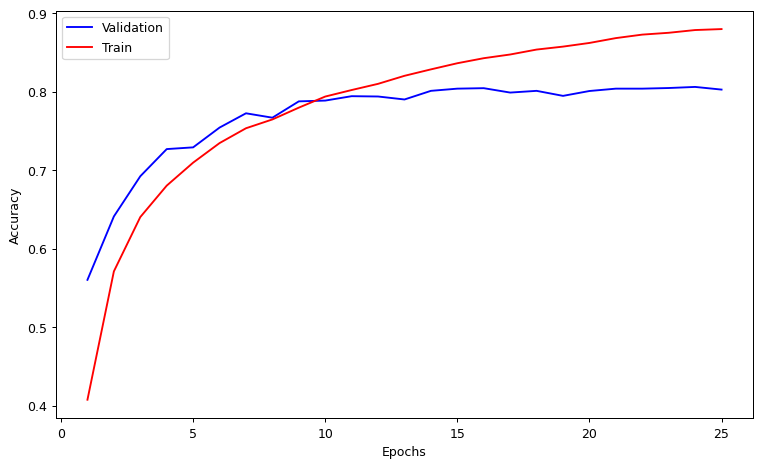

In [22]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.figure(figsize=(10,6), dpi=90)
plt.plot(epochs, val_acc_values, 'b', label='Validation')
plt.plot(epochs, acc_values, 'r', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Применяем сеть для распознавания объектов на изображениях

**Просмотр изображения из набора данных для тестирования**

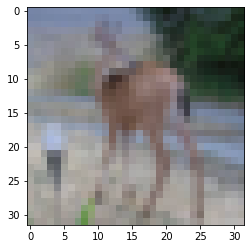

In [28]:
n = 100
plt.imshow(X_test[n])
plt.show()

**Преобразование тестового изображения**

In [29]:
x = X_test[n]
x = np.expand_dims(x, axis=0)

**Запуск распознавания**

In [30]:
prediction = model.predict(x)

**Печатаем результаты распознавания**

In [31]:
print(prediction)

[[2.2818639e-07 9.3204893e-13 1.3132086e-02 2.8028302e-03 8.5648662e-01
  2.5869536e-03 9.5670794e-07 1.2499037e-01 2.9513592e-08 1.5386967e-10]]


**Преобразуем результаты из формата one hot encoding**

In [32]:
prediction = np.argmax(prediction)
print(classes[prediction])

олень


**Печатаем правильный ответ**

In [33]:
print(classes[y_test[n][0]])

олень


## Распознаем дополнительное изображение

In [34]:
from google.colab import files

files.upload()

Saving Авто.png to Авто.png
Saving Грузовик.jpg to Грузовик.jpg
Saving грузовик.png to грузовик.png
Saving кот.png to кот.png
Saving Птица.jpg to Птица.jpg
Saving Самолет.jpg to Самолет.jpg


{'Авто.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xe1\x00\x00\x00\xe1\x08\x03\x00\x00\x00\tm"H\x00\x00\x01&PLTE\xff\xff\xff\xff\x91dPKZb]k\xff\xb4}\xff}Z\xed\xed\xee\xdc\xdb\xde\xff\x8fb\xff\xaey\xffyT\xff\xa9\x93\xff\x83]\xff\x93dRUj\xff\xf5\xf0\xff\x8bZ\xffdd\xe7\x89eUYk\xf4\xf4\xf5\\[kKFV\xff\xb0uE?P;@W\xff\xb2\xa0@FYA;M\xe8\xe7\xe9]Xf\xff\xb2y\xffzd;EY\xff\x9fn\xf8\xb7\xa0\x82\x7f\x88\xef\x8beIIZ\xff\xd5\xc5vcj\xff\xa6s\xff\xb8\x84\xd7\x80a\xb0p_\xbb\xba\xbe\xb6\xb4\xb9\x9c\x9a\xa1\xffsK\xc9\xc8\xcbwt~\x84gj\x94\x86\x89\xa2qh\xff\xe5\xda\xff\xc1\x94\xff\xdb\xc3\xff\xce\xac\xff\xd4\xb7\xce|a\xbdu`\xa7\xa5\xac\x9ch^\xff\x8epolw\xff\xe2\xdb\xff\xd0\xbe\xff\xa4\x7f\xff\xc2\xab\xff\xb3\x95\xea\xd0\xc6\xa3\x96\x98\x91ki\xb3\xa4\xa5\xff\xa0z\xcc\xc2\xc1\xdf\xd5\xd4\xbczg\x80sy\xacth{ah\xff\xc6\x9f\xff\xc7\xc1\xffkb\xff\xd8\xd6\xffSS\xff\x81\x7faQ[\xff\x9b`\x83^\\\xeewY\xd6pZ\xbdiZ\xff\x9f\x88\xc0eS\xd1\xa5\x9e\xa1`Z\xec\xa2\x90\xd6s\x9d\xa4\x00\x00\t@IDATx\x9c\xed\x9ck[\xdbF\

Проверяем загрузку файлов

In [ ]:
!ls

**Смотрим загруженную картинку**

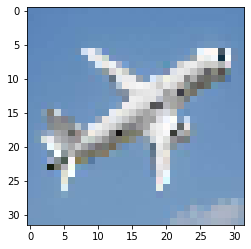

In [50]:
img_path = 'Самолет.jpg'
img = image.load_img(img_path, target_size=(32, 32))
plt.imshow(img)
plt.show()

**Преобразуем картинку в массив для распознавания**

In [51]:
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

**Запускаем распознавание**

In [52]:
prediction = model.predict(x)
prediction = np.argmax(prediction)
print(classes[prediction])

самолет
